In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import  matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, Activation, Flatten,BatchNormalization,Input, Conv1D, MaxPooling1D,LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
import seaborn as sns
from sklearn.decomposition import PCA
import time

In [2]:
data = pd.read_parquet('/kaggle/input/cicids2018/merged10-4.parquet')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8247888 entries, 0 to 8247887
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           float32
 1   Protocol           int8   
 2   Timestamp          int32  
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int32  
 5   Tot Bwd Pkts       int32  
 6   TotLen Fwd Pkts    int64  
 7   TotLen Bwd Pkts    int64  
 8   Fwd Pkt Len Max    int32  
 9   Fwd Pkt Len Min    int32  
 10  Fwd Pkt Len Mean   float32
 11  Fwd Pkt Len Std    float32
 12  Bwd Pkt Len Max    int32  
 13  Bwd Pkt Len Min    int32  
 14  Bwd Pkt Len Mean   float32
 15  Bwd Pkt Len Std    float32
 16  Flow Byts/s        float32
 17  Flow Pkts/s        float32
 18  Flow IAT Mean      float32
 19  Flow IAT Std       float32
 20  Flow IAT Max       int64  
 21  Flow IAT Min       int64  
 22  Fwd IAT Tot        int64  
 23  Fwd IAT Mean       float32
 24  Fwd IAT Std        float32
 25  Fwd IAT Max       

In [4]:
class_dict ={'Benign': 0,'DDOS attack-HOIC': 4,'DoS attacks-Hulk': 7,'Bot': 1,'FTP-BruteForce': 10,'SSH-Bruteforce': 13,'Infilteration': 11,'DoS attacks-SlowHTTPTest': 8,'DoS attacks-GoldenEye': 6,'DoS attacks-Slowloris': 9,'DDOS attack-LOIC-UDP': 5,'Brute Force -Web': 2,'Brute Force -XSS': 3,'SQL Injection': 12}
label_counts = data['Label'].value_counts()
inverse_class_dict = {v: k for k, v in class_dict.items()}
max_name_length = max(len(name) for name in inverse_class_dict.values())
padding_width = max_name_length + 5
print(f"{'Attack ':<{padding_width}} Count")
print("-" * (padding_width + len("Count") + 1))
for label_code, count in label_counts.items():
    attack_name = inverse_class_dict.get(label_code, f"Unknown Label ({label_code})")
    print(f"{attack_name:<{padding_width}} {count}")

Attack                        Count
-----------------------------------
Benign                        6077145
DDOS attack-HOIC              686012
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193354
SSH-Bruteforce                187589
Infilteration                 160639
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP          1730
Brute Force -Web              611
Brute Force -XSS              230
SQL Injection                 87


In [ ]:
X = data.drop('Label', axis=1)
y = data['Label']
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41)
del X,y

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [20]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6598310, 79, 1), (1649578, 79, 1), (6598310,), (1649578,))

# ANN without PCA

In [21]:
ann = Sequential()
ann.add(Dense(128, activation='relu',input_shape=(X_train.shape[1],),kernel_regularizer=l2(0.005)))
ann.add(Dropout(0.2))
ann.add(BatchNormalization())
ann.add(Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
ann.add(Dropout(0.2))
ann.add(BatchNormalization())
ann.add(Dense(128, activation='relu',kernel_regularizer=l2(0.005)))
ann.add(Dropout(0.2))
ann.add(BatchNormalization())
ann.add(Dense(14, activation='softmax'))
ann.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
ann.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,014 (312.55 KB)

 Trainable params: 78,990 (308.55 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [23]:
hist_ann=ann.fit(X_train, y_train, epochs=10, batch_size=128,validation_data=(X_test,y_test))  

Epoch 1/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 109s 2ms/step - accuracy: 0.9571 - loss: 0.5545 - val_accuracy: 0.9813 - val_loss: 0.0644
Epoch 2/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.9812 - loss: 0.0637 - val_accuracy: 0.9820 - val_loss: 0.0565
Epoch 3/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.9813 - loss: 0.0605 - val_accuracy: 0.9825 - val_loss: 0.0538
Epoch 4/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.9812 - loss: 0.0592 - val_accuracy: 0.9821 - val_loss: 0.0553
Epoch 5/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.9811 - loss: 0.0583 - val_accuracy: 0.9823 - val_loss: 0.0560
Epoch 6/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.9811 - loss: 0.0579 - val_accuracy: 0.9823 - val_loss: 0.0558
Epoch 7/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.9812 - loss: 0.0573 - val_accuracy: 0.9823 - val_loss: 0.0628
Epoch 8/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - ac

In [12]:
start_time = time.perf_counter()
y_pred = ann.predict(X_test)
end_time = time.perf_counter()

51550/51550 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step


In [13]:
duration = end_time - start_time
print(f"Time taken for ANN without PCA : {duration:.6f} seconds")

Time taken for ANN without PCA : 94.646276 seconds


In [14]:
print(f"X_test shape: {X_test.shape}")
num_test_samples = X_test.shape[0]
time_per_sample = duration / num_test_samples * 1000
print(f"Time per sample: {time_per_sample:.6f} ms")

X_test shape: (1649578, 79, 1)
Time per sample: 0.057376 ms


In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [28]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted',zero_division=0)
precision = precision_score(y_test, y_pred, average='weighted',zero_division=0)
print(f"Accuracy: {accuracy:.6f}")
print(f"Weighted Recall: {recall:.6f}")
print(f"Weighted Precision: {precision:.6f}")

Accuracy: 0.981770
Weighted Recall: 0.981770
Weighted Precision: 0.977568


# ANN with PCA for n_components = 15

In [3]:
X = data.drop('Label', axis=1)
y = data['Label']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [4]:
pca = PCA(n_components=15,random_state=42)
X_pca = pca.fit_transform(X)
del X

PCA with 15 components
Total Explained Variance: 0.9966


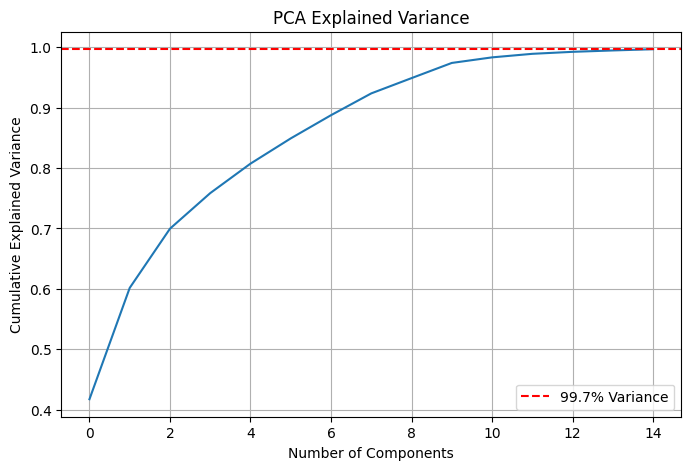

In [5]:
print(f"PCA with {pca.n_components_} components")
print(f"Total Explained Variance: {np.sum(pca.explained_variance_ratio_):.4f}")

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.axhline(y=np.sum(pca.explained_variance_ratio_), color='r', linestyle='--', label=f'{np.sum(pca.explained_variance_ratio_)*100:.1f}% Variance')
plt.legend(loc='best')
plt.show()

In [6]:
explained_variance_ratio = pca.explained_variance_ratio_
components = pca.components_
feature_names=data.drop("Label",axis=1).columns
print("PCA Components and Explained Variance (Concise List):")
for i in range(pca.n_components_):
    pc_name = f"PC{i+1}"
    variance_ratio = explained_variance_ratio[i]
    loadings = components[i]
    feature_loadings = pd.Series(loadings, index=feature_names)
    top_features = feature_loadings.abs().sort_values(ascending=False).head(3) # Top 3 features

    top_feature_names = top_features.index.tolist()
    top_feature_loadings_values = feature_loadings[top_feature_names].tolist()

    print(f"\n{pc_name}: Explained Variance Ratio = {variance_ratio:.4f}")
    for j in range(len(top_feature_names)):
        print(f"  - Top Feature {j+1}: {top_feature_names[j]} ( {top_feature_loadings_values[j]:.2f} )")

PCA Components and Explained Variance (Concise List):

PC1: Explained Variance Ratio = 0.4173
  - Top Feature 1: PSH Flag Cnt ( 0.59 )
  - Top Feature 2: ACK Flag Cnt ( -0.49 )
  - Top Feature 3: RST Flag Cnt ( 0.40 )

PC2: Explained Variance Ratio = 0.1843
  - Top Feature 1: ACK Flag Cnt ( 0.62 )
  - Top Feature 2: Dst Port ( 0.40 )
  - Top Feature 3: Protocol ( -0.36 )

PC3: Explained Variance Ratio = 0.0980
  - Top Feature 1: PSH Flag Cnt ( 0.58 )
  - Top Feature 2: Protocol ( -0.46 )
  - Top Feature 3: ECE Flag Cnt ( -0.37 )

PC4: Explained Variance Ratio = 0.0589
  - Top Feature 1: Init Fwd Win Byts ( 0.68 )
  - Top Feature 2: Dst Port ( 0.44 )
  - Top Feature 3: Init Bwd Win Byts ( -0.32 )

PC5: Explained Variance Ratio = 0.0488
  - Top Feature 1: Dst Port ( 0.68 )
  - Top Feature 2: Init Fwd Win Byts ( -0.44 )
  - Top Feature 3: URG Flag Cnt ( 0.37 )

PC6: Explained Variance Ratio = 0.0418
  - Top Feature 1: SYN Flag Cnt ( 0.57 )
  - Top Feature 2: Fwd PSH Flags ( 0.57 )
  - Top

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42)

In [6]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [7]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6598310, 15, 1), (1649578, 15, 1), (6598310,), (1649578,))

In [8]:
ann_pca = Sequential()
ann_pca.add(Dense(128, activation='relu',input_shape=(X_train.shape[1],)))
ann_pca.add(Dropout(0.2))
ann_pca.add(BatchNormalization())
ann_pca.add(Dense(256, activation='relu'))
ann_pca.add(Dropout(0.2))
ann_pca.add(BatchNormalization())
ann_pca.add(Dense(128, activation='relu'))
ann_pca.add(Dropout(0.2))
ann_pca.add(BatchNormalization())
ann_pca.add(Dense(14, activation='softmax'))
ann_pca.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
ann_pca.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,822 (280.55 KB)

 Trainable params: 70,798 (276.55 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [10]:
best_weights_filepath = 'ann.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=best_weights_filepath,
    monitor='val_accuracy',       
    save_best_only=True,          
    mode='max',                   
    verbose=1                     
)

In [11]:
hist_ann_pca=ann_pca.fit(X_train, y_train, epochs=10, batch_size=128,validation_data=(X_test,y_test)) 

Epoch 1/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - accuracy: 0.9567 - loss: 0.1727 - val_accuracy: 0.9821 - val_loss: 0.0498
Epoch 2/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 93s 2ms/step - accuracy: 0.9815 - loss: 0.0529 - val_accuracy: 0.9822 - val_loss: 0.0461
Epoch 3/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 93s 2ms/step - accuracy: 0.9817 - loss: 0.0494 - val_accuracy: 0.9823 - val_loss: 0.0443
Epoch 4/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.9818 - loss: 0.0473 - val_accuracy: 0.9828 - val_loss: 0.0409
Epoch 5/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 93s 2ms/step - accuracy: 0.9819 - loss: 0.0456 - val_accuracy: 0.9825 - val_loss: 0.0403
Epoch 6/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 93s 2ms/step - accuracy: 0.9820 - loss: 0.0440 - val_accuracy: 0.9831 - val_loss: 0.0393
Epoch 7/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.9822 - loss: 0.0424 - val_accuracy: 0.9825 - val_loss: 0.0401
Epoch 8/10
51550/51550 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy:

In [18]:
start_time = time.perf_counter()
y_pred = ann_pca.predict(X_test)
end_time = time.perf_counter()

51550/51550 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step


In [19]:
duration = end_time - start_time
print(f"Time taken for ANN with PCA : {duration:.6f} seconds")

Time taken for ANN with PCA : 78.230200 seconds


In [20]:
print(f"X_test shape: {X_test.shape}")
num_test_samples = X_test.shape[0]
time_per_sample = duration / num_test_samples * 1000
print(f"Time per sample: {time_per_sample:.6f} ms")

X_test shape: (1649578, 15, 1)
Time per sample: 0.047424 ms


In [ ]:
# model.save("sample_ann.keras")
# model.save("upsample_ann.h5")

In [12]:
y_pred = ann_pca.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

51550/51550 ━━━━━━━━━━━━━━━━━━━━ 59s 1ms/step


In [13]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title(f'Training and validation accuracy for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title(f'Training and validation loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

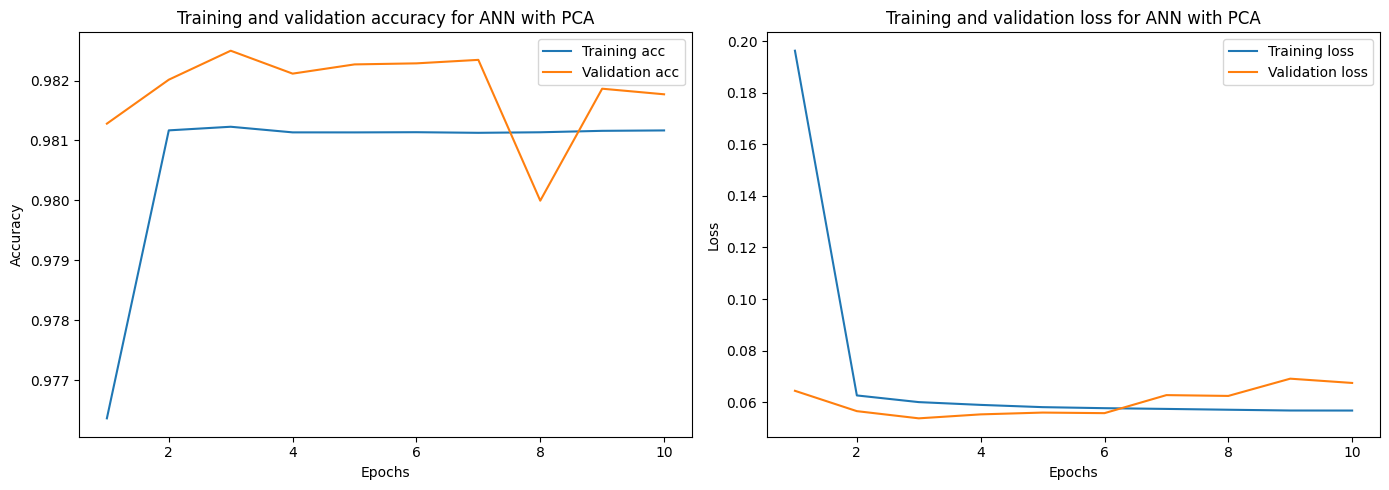

In [30]:
plot_history(hist_ann, "ANN without PCA")

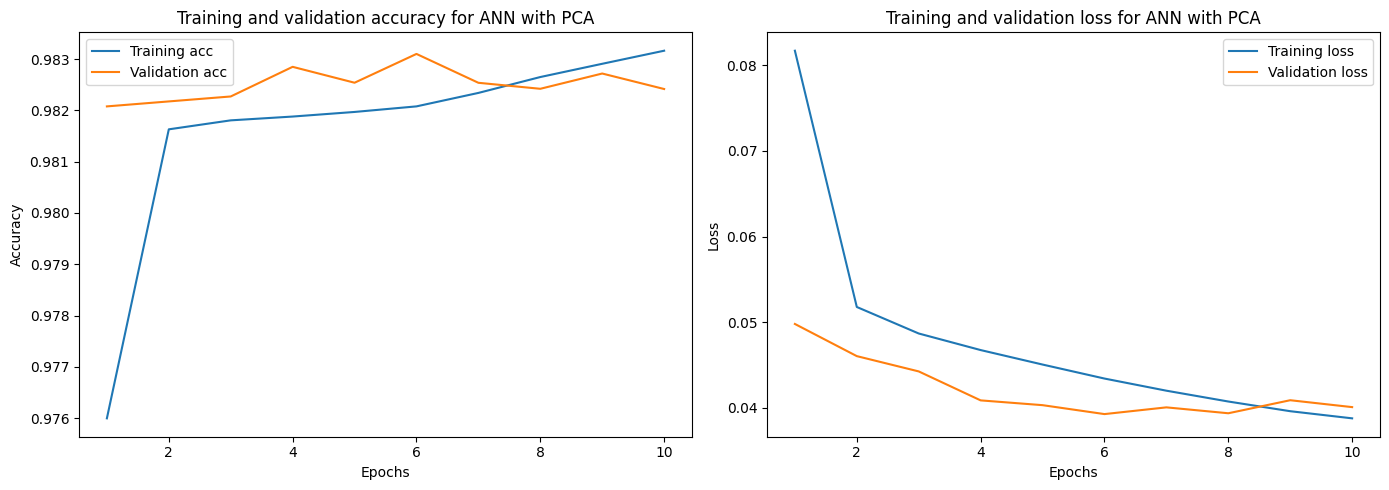

In [14]:
plot_history(hist_ann_pca, "ANN with PCA")

In [15]:
class_dict ={
    'Benign': 0,
    'DDOS attack-HOIC': 4,
    'DoS attacks-Hulk': 7,
    'Bot': 1,
    'FTP-BruteForce': 10,
    'SSH-Bruteforce': 13,
    'Infilteration': 11,  
    'DoS attacks-SlowHTTPTest': 8,
    'DoS attacks-GoldenEye': 6,
    'DoS attacks-Slowloris': 9,
    'DDOS attack-LOIC-UDP': 5,
    'Brute Force -Web': 2,
    'Brute Force -XSS': 3,
    'SQL Injection': 12
}

report_labels_codes = sorted(class_dict.values())
inverse_class_dict = {v: k for k, v in class_dict.items()}
report_target_names = [inverse_class_dict[code] for code in report_labels_codes]
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                           labels=report_labels_codes,      
                           target_names=report_target_names, 
                           zero_division=0,
                           digits=4))


Classification Report:
                          precision    recall  f1-score   support

                  Benign     0.9822    0.9942    0.9882   1216289
                     Bot     0.9987    0.9989    0.9988     56957
        Brute Force -Web     0.5882    0.4673    0.5208       107
        Brute Force -XSS     0.0000    0.0000    0.0000        47
        DDOS attack-HOIC     1.0000    1.0000    1.0000    136973
    DDOS attack-LOIC-UDP     0.0000    0.0000    0.0000       327
   DoS attacks-GoldenEye     0.9996    0.9985    0.9991      8251
        DoS attacks-Hulk     0.9997    1.0000    0.9999     92590
DoS attacks-SlowHTTPTest     1.0000    1.0000    1.0000     27692
   DoS attacks-Slowloris     0.9900    0.9945    0.9923      2195
          FTP-BruteForce     1.0000    1.0000    1.0000     38427
           Infilteration     0.6064    0.3327    0.4297     32103
           SQL Injection     0.0000    0.0000    0.0000        16
          SSH-Bruteforce     0.9999    1.0000    0.

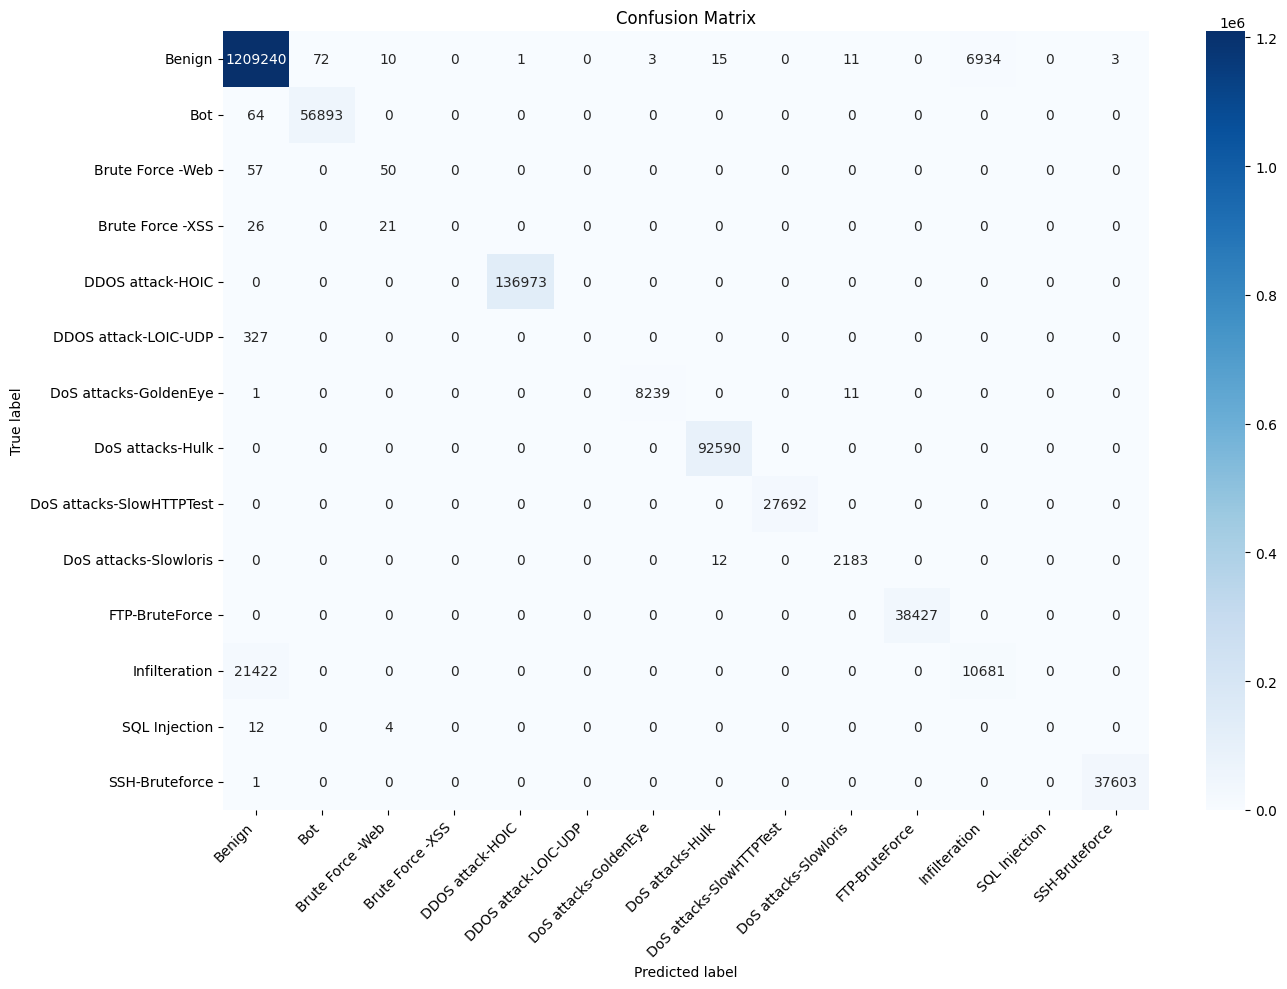

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=report_labels_codes)
plt.figure(figsize=(14,10))

sns.heatmap(cm,
            annot=True,       
            fmt='d',          
            cmap='Blues',     
            xticklabels=report_target_names, 
            yticklabels=report_target_names) 
plt.xticks(rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.tight_layout()

plt.show()